Vectorization for Speed

In [40]:
import math
import time
from mxnet import autograd, gluon, np, npx
from d2l import mxnet as d2l
from mxnet.gluon import nn
from mxnet import init

In [2]:
n = 10000
a = np.ones(n)
b = np.ones(n)


In [3]:
class Timer: #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """Start the timer."""
        self.tik = time.time()
    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)
    def sum(self):
        """Return the sum of time."""
        return sum(self.times)
    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [4]:
c = np.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'4.63056 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00099 sec'

The Normal Distribution and Squared Loss

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

Linear Regression Implementation from Scratch

In [12]:
%matplotlib inline
import random
from mxnet import autograd, np, npx
from d2l import mxnet as d2l
npx.set_np()

In [13]:
def synthetic_data(w, b, num_examples): #@save
    """Generate y = Xw + b + noise."""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


In [14]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [15]:
print('features:', features[0], '\nlabel:', labels[0])

features: [1.1630785 2.2122061] 
label: [-1.0015316]


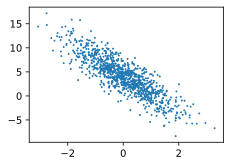

In [16]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1);


In [17]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [18]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 0.9695946   0.5721275 ]
 [-2.067554   -0.5190514 ]
 [-1.4747816  -0.22913499]
 [-1.4001248  -0.15206735]
 [ 0.9702774  -0.97275484]
 [ 0.38731197 -1.116601  ]
 [ 1.3801025   0.16687097]
 [-0.22240956  1.1812508 ]
 [ 0.3951814   0.05316188]
 [ 0.03400987 -0.6008752 ]] 
 [[ 4.186712  ]
 [ 1.8293495 ]
 [ 2.0427856 ]
 [ 1.9252956 ]
 [ 9.44903   ]
 [ 8.772579  ]
 [ 6.3995743 ]
 [-0.23802496]
 [ 4.797605  ]
 [ 6.314965  ]]


In [19]:
w = np.random.normal(0, 0.01, (2, 1))
b = np.zeros(1)
w.attach_grad()
b.attach_grad()


In [20]:
def linreg(X, w, b): #@save
    """The linear regression model."""
    return np.dot(X, w) + b

In [21]:
def squared_loss(y_hat, y): #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [22]:
def sgd(params, lr, batch_size): #@save
    """Minibatch stochastic gradient descent."""
    for param in params:
        param[:] = param - lr * param.grad / batch_size

In [28]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [29]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y) # Minibatch loss in `X` and `y`
# Because `l` has a shape (`batch_size`, 1) and is not a scalar
# variable, the elements in `l` are added together to obtain a new
# variable, on which gradients with respect to [`w`, `b`] are computed
        l.backward()
        sgd([w, b], lr, batch_size) # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [30]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')


error in estimating w: [0.00054181 0.00030112]
error in estimating b: [0.00049782]


In [32]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)


In [33]:
def load_array(data_arrays, batch_size, is_train=True): #@save
    """Construct a Gluon data iterator."""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [36]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [37]:
next(iter(data_iter))


[array([[ 0.31359258,  0.13827525],
        [-1.7247454 ,  1.867847  ],
        [-0.40836138, -0.6448437 ],
        [-2.5377548 , -0.4433322 ],
        [ 1.0337256 ,  0.05897086],
        [-1.2724168 , -0.7200827 ],
        [ 0.53822994,  0.1565786 ],
        [ 1.4826194 ,  0.5006266 ],
        [-1.027462  ,  2.1428792 ],
        [ 0.26142934,  1.1591797 ]]),
 array([[ 4.3699293],
        [-5.6030674],
        [ 5.571419 ],
        [ 0.6240849],
        [ 6.0606833],
        [ 4.0960393],
        [ 4.731808 ],
        [ 5.4619236],
        [-5.1359773],
        [ 0.7903588]])]

In [39]:
net = nn.Sequential()
net.add(nn.Dense(1))

In [41]:
net.initialize(init.Normal(sigma=0.01))


In [42]:
loss = gluon.loss.L2Loss()

In [43]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

In [44]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l.mean().asnumpy():f}')

epoch 1, loss 0.035134
epoch 2, loss 0.000123
epoch 3, loss 0.000049


In [45]:
w = net[0].weight.data()
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
b = net[0].bias.data()
print(f'error in estimating b: {true_b - b}')

error in estimating w: [-0.00025558 -0.00053144]
error in estimating b: [0.0004406]
